In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import folium
from folium.plugins import MarkerCluster
import geopy.distance

In [3]:
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [4]:
train = pd.read_csv('/content/drive/MyDrive/데이콘/퇴근시간버스승차예측/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/데이콘/퇴근시간버스승차예측/data/test.csv')

In [5]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


date 컬럼을 판다스의 datetime 변수형으로 변환.

In [12]:
train['date2'] = pd.to_datetime(train['date'])
print(train['date2'])

0        2019-09-01
1        2019-09-01
2        2019-09-01
3        2019-09-01
4        2019-09-01
            ...    
415418   2019-09-30
415419   2019-09-30
415420   2019-09-30
415421   2019-09-30
415422   2019-09-30
Name: date2, Length: 415423, dtype: datetime64[ns]


weekday

Return day of week as integer, where Monday is 0 and Sunday is 6

In [17]:
train['weekday'] = train['date2'].dt.weekday
print(train['weekday'])

0         6
1         6
2         6
3         6
4         6
         ..
415418    0
415419    0
415420    0
415421    0
415422    0
Name: weekday, Length: 415423, dtype: int64


weekday 변수 생성 후 pandas의 get_dummies 함수를 활용하여 weekday에 대한 one hot encoding을 실행.

In [18]:
train = pd.get_dummies(train, columns=['weekday'])
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,date2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2019-09-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,2019-09-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2019-09-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2019-09-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2019-09-01,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [19]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test, columns=['weekday'])

In [20]:
del train['date2']
del test['date2']

In [21]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

시외인 것이 매우 적다.

시외를 1로, 시내를 0으로 변환.


In [22]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

In [23]:
test['in_out'] = test['in_out'].map({'시내':0, '시외':1})

## 승차, 하차 시간대 통합 작업

train, test data는 오전 시간대의 경우, 1시간마다의 승차, 하차 인원수를 표시

예측하려고 하는 퇴근시간대의 경우, 2시간에 해당되는 승차 인원을 예측.

그렇기 때문에, 오전 시간대에 승차, 하차 인원수들도 2시간 간격으로 통합.



In [24]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

해당 통합 작업 이후 생성된 변수와 퇴근 시간대의 승차 인원의 상관관계를 확인하기 위하여 heatmap 생성.


Text(0.5, 1.0, 'arrive and leave correlation graph')

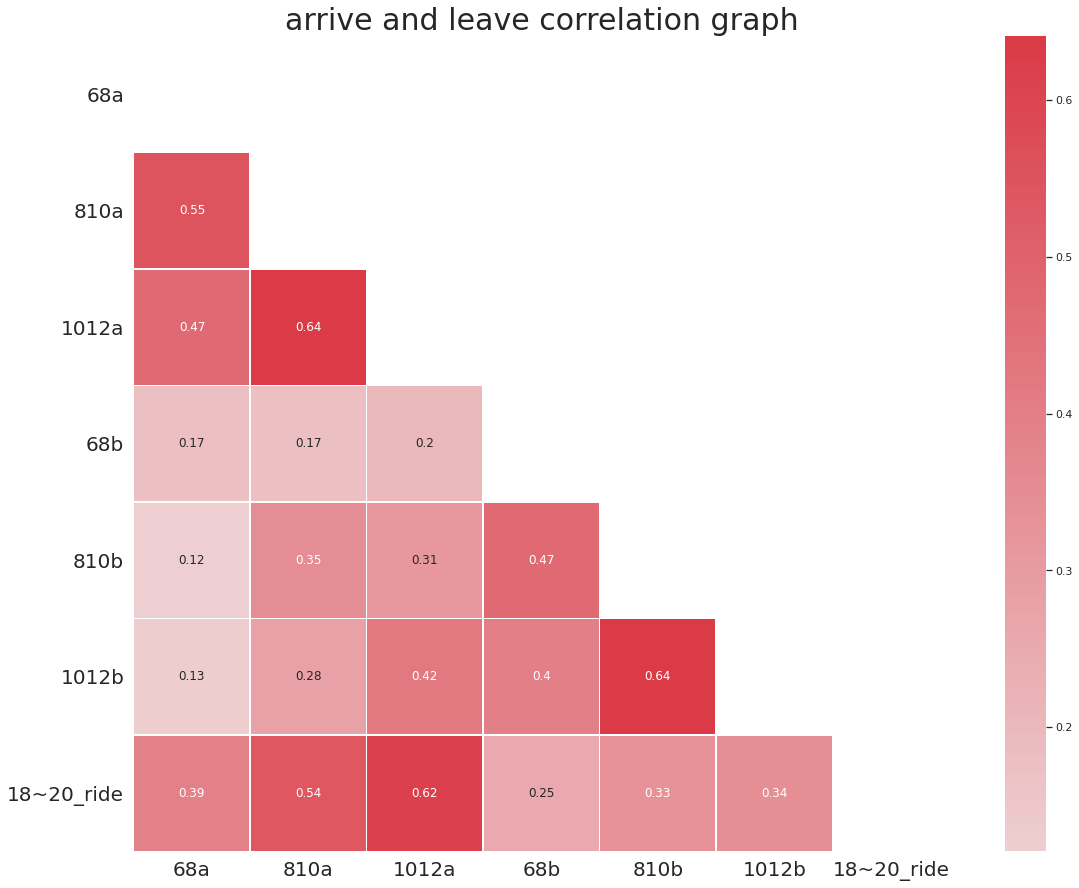

In [26]:
train22 = train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]
cor = train22.corr()
sns.set(style='white')
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink":1}, annot=True)
plt.xticks(size=20)
plt.yticks(size=20, rotation=0)
plt.title('arrive and leave correlation graph', size=30)

In [27]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

## 좌표 데이터를 이용한 Feature Engineering

### 측정소 위치 및 정류장 위치 확인
인구가 서귀포시와 제주시에 몰려 있는 경우가 많으며, 해당 지역 및 서쪽 동쪽 지역의 위치를 활용

해당 지역과의 거리를 feature로 추가

2개 좌표 간의 거리를 구하는 함수는 파이썬의 geopy 패키지에 존재.

In [28]:
# 해당 주요 장소의 임의 지역 위도, 경도
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [29]:
map_osm = folium.Map((33.399835, 126.506031), zoom_start=9)
mc = MarkerCluster()

In [30]:
mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [31]:
data = train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

In [33]:
data2 = data.groupby(['station_name'])['latitude','longitude'].mean()
data2.to_csv('folium.csv')
data2 = pd.read_csv('folium.csv')

In [35]:
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude, row.longitude], popup=row.station_name))
    map_osm.add_child(mc)
map_osm

같은 정류장의 이름이 있는 것이 2개인 경우, 

위도 경도의 평균을 적용한 다음 시각화를 하여서

해당 정류장들의 위치를 확인한 결과는 다음과 같다.

## 측정소와 정류장 사이 거리 계산 적용

2개의 좌표 간의 거리를 구하는 함수를 파이썬의 geopy 패키지에 존재.


geopy.distance.vincenty를 이용하여, m 단위 혹은 km 단위로 계산이 가능.
dis_jeju : 버스정류장과 제주 측정소와의 거리

dis_gosan : 버스정류장과 고산 측정소시와의 거리

dis_seongsan : 버스정류장과 성산 측정소와의 거리

dis_po : 버스정류장과 서귀포 측정소와의 거리

각 정류장과 제주도에 존재하는 4군데의 기상 측정소와의 거리를 계산하여 t1~t4에 할당


In [36]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

각 측정소와 정류소 사이의 거리를 계산한 다음,

해당 정류소에서 가장 가까운 곳에 있는 측정소를 dist_name 변수의 값으로 넣는다.



In [38]:
total = pd.DataFrame(list(zip(t1,t2,t3,t4)), columns=['jeju','gosan','seongsan','po'])
print(total)
train['dist_name'] = total.apply(lambda x:x.argmin(), axis=1)
print(train['dist_name'])
data22 = train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')
print(data22)
Counter(data22['dist_name'])

             jeju      gosan   seongsan         po
0        4.286659  37.692766  37.713630  27.841879
1        4.966848  37.008492  38.465822  27.996179
2        6.330746  35.642126  39.259820  27.496551
3        3.575272  38.643401  38.386802  29.579404
4       30.652098  23.648361  45.899140  14.269792
...           ...        ...        ...        ...
415418  27.117280  16.319339  57.465292  33.738981
415419   2.134693  39.904297  36.202951  28.484278
415420  40.039090  11.626985  60.041783  28.249863
415421  20.355649  23.876917  52.933244  33.392008
415422  29.502808  32.543755  37.889853   5.348404

[415423 rows x 4 columns]
0         0
1         0
2         0
3         0
4         3
         ..
415418    1
415419    0
415420    1
415421    0
415422    3
Name: dist_name, Length: 415423, dtype: int64
        station_name  latitude  longitude  dist_name
0              제주썬호텔  33.48990  126.49373          0
1               한라병원  33.48944  126.48508          0
2               정존마을  33

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

현재 전체 정류장별 어느 측정소와 가장 가까운지 counter를 통해서 확인이 가능.
test_data에도 적용.

In [46]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

## 외부 실제 측정 데이터 활용

외부 데이터 중 오전 시간대의 실제 측정 데이터를 활용하여서 변수로 활용.

외부데이터 사용기간은 2019.09.01 ~ 10.16일이며 해당 데이터를 불러온 뒤, 06~11시에 해당되는 사항들만 편집하여서 사용.

data leakage에 해당되지 않는다.



In [47]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po']
           #'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

현재 randomforest regressor의 최적의 parameter를 찾는 과정을 GridSearchCV를 활용하여 수행하려고 한다.

하지만, 전체 데이터를 사용하여서 최적의 paramter를 찾으려고 하는 경우, 시간이 매우 오래 걸리기 때문에

train data의 1%에 해당되는 데이터만 활용하여서 최적의 parameter 값을 찾고 이를 전체 train data에 학습시키려고 한다.

In [48]:
X_train = train[input_var]

In [49]:
random.seed(1217)

In [50]:
train_list = random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.001,0)))

In [51]:
X_train = train[input_var]
X_train = X_train.iloc[train_list,:]
y_train = train[target]
y_train = y_train.iloc[train_list,:]
X_test = test[input_var]
X_train.shape, y_train.shape

((415, 34), (415, 1))

In [52]:
param_grid = {
    'max_features':[2,3,5],
    'min_samples_leaf':[2,3],
    'min_samples_split':[2,4,6],
    'n_estimators': [100,200,500]
}

In [53]:
rf = RandomForestRegressor(random_state=1217) #랜덤포레스트 모델 정의
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid) #GridSearchCV 정의
grid_search.fit(X_train, y_train) #학습이후 최적의 parameter를 출력
grid_search.best_params_

{'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [54]:
X_train=train[input_var]
y_train=train[target]
X_test=test[input_var]
X_train.shape, y_train.shape, X_test.shape

((415423, 34), (415423, 1), (228170, 34))

In [55]:
rf = RandomForestRegressor(max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=1217)
rf.fit(X_train, y_train)
test['18~20_ride'] = rf.predict(X_test)
test[['id','18~20_ride']].to_csv("dacon_base_middle2.csv", index=False)